## Data Preparation

In [1]:
import pandas as pd
df = (
    pd.read_csv("df_clean.csv", index_col = 0)
    .assign(action_token = lambda d: pd.Categorical(d.action_token))
)

vocab = df['action_token'].cat.categories

df

,match_id,action_token,dataset
0,315,"True,pass,4,4",train
1,315,"True,receival,4,5",train
2,315,"True,dribble,4,5",train
3,315,"True,pass,5,5",train
4,315,"True,receival,6,4",train
...,...,...,...
939915,82,"False,receival,8,0",test
939916,82,"False,dribble,8,0",test
939917,82,"True,tackle,9,0",test
939918,82,"True,dribble,9,0",test


## Prepare Model

In [3]:
import torch
from models.transformer import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)
model.load_state_dict(torch.load("checkpoints/model1_epoch4.pt", map_location=torch.device('cuda')))
model.eval()

/home/daniel/miniconda3/envs/csc413/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=500, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=500, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=50, out_features=3015, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (input_emb): Embedding(3015, 50)
)

In [4]:
counts = pd.read_csv("transition_counts.csv", index_col = 0)
counts_smoothed = counts + 1
probs = counts_smoothed / counts_smoothed.sum()

def pred_markov(tok):
    return vocab[counts[tok].argmax()]

def prob_markov(tok1, tok2):
    return probs[tok1][tok2]

## Quantitative Evaluation

In [5]:
markov_results = (
    df
    .assign(
        y_true = lambda d: d.action_token.shift(-1),
        y_pred_markov = lambda d: d.action_token.apply(pred_markov),
        accuracy_markov = lambda d: d.y_true == d.y_pred_markov
    )
    .dropna()
    .assign(
        p_markov = lambda d: d.apply(lambda x: prob_markov(x.action_token, x.y_true), axis=1)
    )
)

markov_results

,match_id,action_token,dataset,y_true,y_pred_markov,accuracy_markov,p_markov
0,315,"True,pass,4,4",train,"True,receival,4,5","True,receival,5,5",False,0.010556
1,315,"True,receival,4,5",train,"True,dribble,4,5","True,dribble,4,5",True,0.223239
2,315,"True,dribble,4,5",train,"True,pass,5,5","True,pass,4,5",False,0.014695
3,315,"True,pass,5,5",train,"True,receival,6,4","True,receival,4,4",False,0.006934
4,315,"True,receival,6,4",train,"True,dribble,6,4","True,dribble,6,4",True,0.205905
...,...,...,...,...,...,...,...
939914,82,"False,pass,7,0",test,"False,receival,8,0","False,receival,6,0",False,0.018408
939915,82,"False,receival,8,0",test,"False,dribble,8,0","False,dribble,8,0",True,0.172009
939916,82,"False,dribble,8,0",test,"True,tackle,9,0","False,pass,8,0",False,0.003123
939917,82,"True,tackle,9,0",test,"True,dribble,9,0","True,dribble,9,0",True,0.012804


In [15]:
import numpy as np
X = np.lib.stride_tricks.sliding_window_view(df['action_token'].map(list(vocab).index), (9,))

data_loader = torch.utils.data.DataLoader(
    list(zip(X[:-1], X[1:, -1])),
    batch_size=1,
    shuffle=False
)

preds = np.concatenate([model(x_bat.to(device = device))[:, -1, :].argmax(dim = 1).cpu().numpy() for x_bat, y_bat in data_loader])
preds.shape

In [13]:
results = (
    markov_results
    .iloc[8:]
    .assign(
        y_pred_transformer = vocab[preds],
        accuracy_transformer = lambda d: d.y_true == d.y_pred_transformer
    )
)

results

,match_id,action_token,dataset,y_true,y_pred_markov,accuracy_markov,p_markov,y_pred_transformer,accuracy_transformer
8,315,"True,dribble,6,2",train,"True,pass,6,2","True,pass,6,2",True,0.124765,"True,pass,6,2",True
9,315,"True,pass,6,2",train,"True,receival,5,3","True,receival,5,0",False,0.012551,"True,receival,5,0",False
10,315,"True,receival,5,3",train,"True,dribble,5,3","True,dribble,5,3",True,0.236842,"True,dribble,5,3",True
11,315,"True,dribble,5,3",train,"True,pass,5,2","True,pass,5,3",False,0.028551,"True,pass,5,3",False
12,315,"True,pass,5,2",train,"True,receival,4,0","True,receival,5,0",False,0.013072,"True,receival,5,0",False
...,...,...,...,...,...,...,...,...,...
939914,82,"False,pass,7,0",test,"False,receival,8,0","False,receival,6,0",False,0.018408,"False,receival,7,1",False
939915,82,"False,receival,8,0",test,"False,dribble,8,0","False,dribble,8,0",True,0.172009,"False,dribble,8,0",True
939916,82,"False,dribble,8,0",test,"True,tackle,9,0","False,pass,8,0",False,0.003123,"False,pass,8,0",False
939917,82,"True,tackle,9,0",test,"True,dribble,9,0","True,dribble,9,0",True,0.012804,"True,dribble,9,0",True


In [14]:
import numpy as np
def mean_log_likelihood(probs):
    return np.log(probs).mean()

(
    results
    .groupby('dataset')
    .agg({'accuracy_markov': 'mean', 'accuracy_transformer': 'mean', 'p_markov': mean_log_likelihood})
)

,accuracy_markov,accuracy_transformer,p_markov
dataset,,,
test,0.424458,0.427753,-4.070005
train,0.419517,0.423723,-4.037134
val,0.417171,0.421788,-4.109214


## Plot Generated Plays

In [ ]:
!pip install matplotsoccer


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import matplotsoccer as pltsoc

def x_bin_to_coords(bin):
    return (float(bin) + 0.5) * 10.5

def y_bin_to_coords(bin):
    return (float(bin) + 0.5) * 6.8

def plot_action_sequence(tokens):
    team = ["home" if t.split(',')[0] == "True" else "away" for t in tokens]
    action = [t.split(',')[1] for t in tokens]
    x_coord = [x_bin_to_coords(t.split(',')[2]) for t in tokens]
    y_coord = [y_bin_to_coords(t.split(',')[3]) for t in tokens]
    coords = list(zip(x_coord, y_coord))

    pltsoc.actions(
        coords,
        team = team,
        action_type = action,
        label = [[team[i], action[i]] for i in range(len(team))],
        labeltitle=["team","action type"]
    )

C:\Users\ethan\AppData\Local\Temp\ipykernel_13272\1708682437.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)


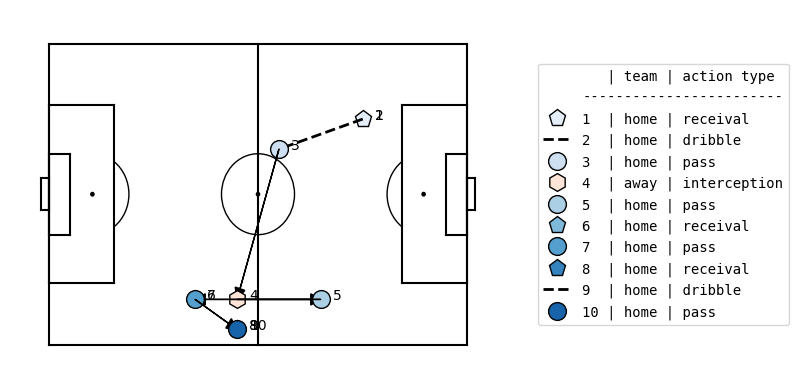

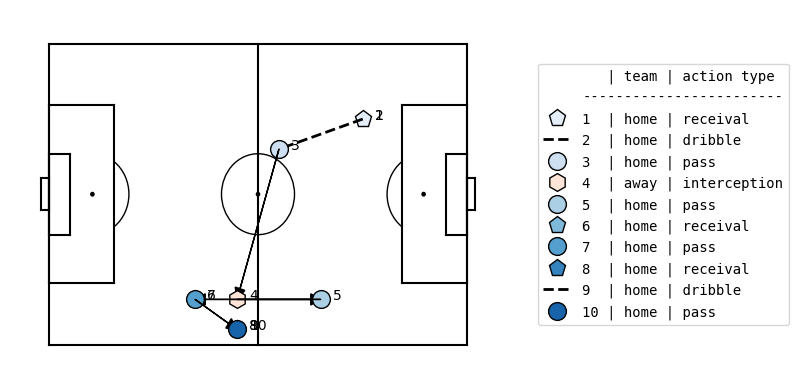

In [ ]:
pid = 200

model.eval()
output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)
play = output[0,-1].item()
sequence = list(X_train[pid]) + [play]
plot_action_sequence([vocab[i] for i in sequence])

output = pred_markov(X_train[pid][-1])
sequence = list(X_train[pid]) + [output]
plot_action_sequence([vocab[i] for i in sequence])


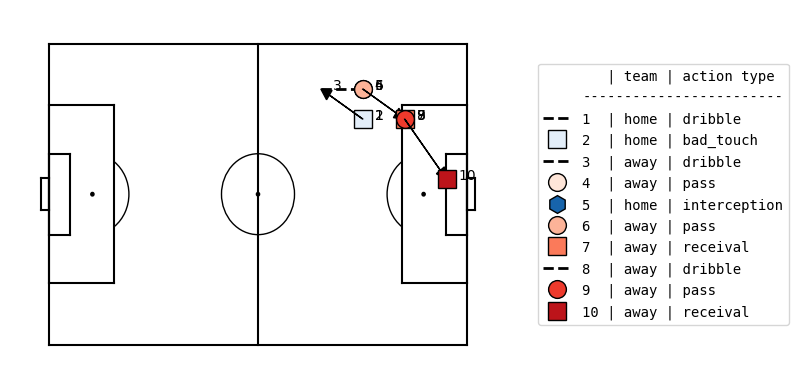

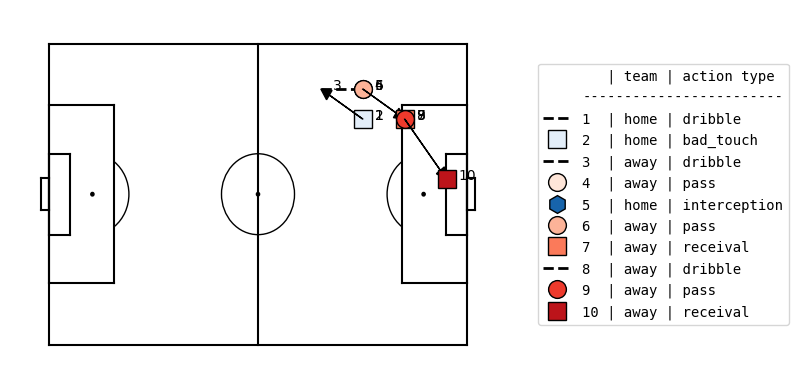

In [ ]:
pid = 2000

model.eval()
output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)
play = output[0,-1].item()
sequence = list(X_train[pid]) + [play]
plot_action_sequence([vocab[i] for i in sequence])

output = pred_markov(X_train[pid][-1])
sequence = list(X_train[pid]) + [output]
plot_action_sequence([vocab[i] for i in sequence])
